In [1]:
import numpy as np
import sys
import random
import os
import optparse
from os.path import isfile, join
caffe_root = '/raid/yufeihome/caffe_1/'
sys.path.insert(1,caffe_root + 'python')
import caffe
from os import listdir
#sys.path.insert(2,'/home/feiyu1990/libs/liblinear-1.94/python')
#from liblinearutil import *
import cPickle
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import operator
import matplotlib.cm as cm
from scipy.misc import imresize
%matplotlib inline
from scipy.stats import pearsonr, spearmanr
from scipy.io import savemat
from sklearn import metrics

cross_number = 5
train_portion = 0.8
test_portion = 0.2
root = 'CNN_cross1'
save_root = 'Analysis_2/CNN_cross1/'
background_root = 'no_finetune_cross1/'
foreground_root = 'no_finetune_cross1_foreground/'


imagenet_model = '/raid/yufeihome/caffe/examples/imagenet/caffe_reference_imagenet_model'
woratiofine_folder_name = '/result_background_woratiofine/'
imagenet_deploy = '/raid/yufeihome/caffe/examples/imagenet/imagenet_deploy.prototxt'
urban_deploy = '/raid/yufeihome/urban_tribe/caffe/finetune_bratio/codes/finetune_deploy.prototxt'
classes = ['hipster','ravers', 'biker','country','goth','hiphop','others','surfer','clubber','formal','heavy']


#foreground_fine_path = 'foreground_fine'
#foreground_feature = 'optimal_new/'
#background_dense_path = 'background_dense'
#background_sparse_path = 'background_ratio'
#background_woratio_path = 'background_woratio'
#background_woratiofine_path = 'background_woratiofine'
#foreground_woratiofine_path = 'foreground_woratiofine'

In [2]:
    cross_portion = 0.0
    urban_model = '/raid/yufeihome/urban_tribe/caffe/finetune_bratio/'+background_root+str(cross_portion)+'/background_iter_3000'
    net = caffe.Classifier(urban_deploy,urban_model,image_dims=[256,256])
    net.set_phase_test()
    net.set_mode_gpu()
    net.set_mean('data',caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    net.set_channel_swap('data',(2,1,0))
    net.set_input_scale('data',255)

# GENERAL FUNCTIONS

In [3]:
def get_pool_indice(net,layer_number, no_feature_map):
    pool_layer = 'pool'+str(layer_number)
    conv_layer = 'conv'+str(layer_number)
    pool_indice= np.zeros(net.blobs[pool_layer].data.shape, dtype='int')
    #print pool_indice.shape
    for i in xrange(0,net.blobs[conv_layer].data.shape[2]-1,2):
        for j in xrange(0,net.blobs[conv_layer].data.shape[3]-1,2):
            temp = net.blobs[conv_layer].data[4,:,i:i+3,j:j+3]
            #print temp.shape
            if temp.shape[1]!=3:
                    temp = np.append(temp,np.zeros((temp.shape[0],3-temp.shape[1],temp.shape[2])),axis=1)
            if temp.shape[2]!=3:
                    temp = np.append(temp,np.zeros((temp.shape[0],temp.shape[1],3-temp.shape[2])),axis=2)
            pool_indice[0,:,i/2,j/2]=np.argmax(np.reshape(temp,(temp.shape[0],9)),axis=1)
            for k in xrange(net.blobs[conv_layer].data.shape[1]):
                if(np.max(temp[k,:,:])==0):
                    pool_indice[0,k,i/2,j/2]=-1
    #print pool_indice[0,:,:,:].shape, net.blobs[conv_layer].data[4,:,:,:].shape
    return pool_indice[0,:,:,:]

def unpooling_layer(inputs, indice, outputs_shape):
    outputs = np.zeros(outputs_shape)
    for i in xrange(indice.shape[1]):
        for j in xrange(indice.shape[2]):
            for k in xrange(indice.shape[0]):
                index = indice[k,i,j]
                if(index == -1):
                    continue
                x_offset = index/3;y_offset = index-x_offset*3
                outputs[k,i*2+x_offset,y_offset+j*2] = inputs[k,i,j]
    return outputs

def conv_layer(inputs,filters,bias,method = 'full'):
    filters = np.transpose(filters,(1,0,2,3))
    #print 'deconv filter shape:', filters.shape
    #filters = filters[:,:,::-1,::-1]
    filter_shape = filters.shape
    outputs = np.zeros((filter_shape[0],inputs.shape[1]+filters.shape[2]-1,inputs.shape[2]+filters.shape[3]-1))
    if method=='full':
        outputs = np.zeros((filter_shape[0],inputs.shape[1]+filters.shape[2]-1,inputs.shape[2]+filters.shape[3]-1))
    else:
        outputs = np.zeros((filter_shape[0],inputs.shape[1],inputs.shape[2]))
    #print inputs.shape, outputs.shape
    intputs = inputs-bias
    for i in xrange(filter_shape[0]):
        for j in xrange(filter_shape[1]):
            outputs[i,:,:] += convolve2d(inputs[j,:,:], filters[i,j,:,:],method)
    return outputs

def relu_layer(inputs):
    outputs = np.maximum(inputs,np.zeros(inputs.shape))
    return outputs

def unpooling_layer_no_param(inputs):
    inputs_shape = inputs.shape
    outputs_shape = [inputs_shape[0],inputs_shape[1]*2+1, inputs_shape[2]*2+1]
    outputs = np.zeros(outputs_shape)
    for i in xrange(inputs_shape[1]):
        for j in xrange(inputs_shape[2]):
            outputs[:,i*2,j*2] = inputs[:,i,j]
    return outputs


In [4]:
def net_extract(net,image_name):
    imageset_root = '/raid/yufeihome/urban_tribe/pictures_all/'      
    mean = np.load(caffe_root+'/python/caffe/imagenet/ilsvrc_2012_mean.npy')
    small_size = 256
    net.predict([caffe.io.load_image(imageset_root+image_name)])

# RECONSTRUCTION OF CONV5

In [7]:
def recon_conv5(net, no_feature_map, pool1_indice, pool2_indice):
    inputs = net.blobs['conv5'].data[4,no_feature_map:no_feature_map+1,:,:]
    temp = np.squeeze(net.blobs['conv5'].data[4,no_feature_map:no_feature_map+1,:,:])
    print 'conv5 blob shape:', temp.shape
    index = np.argmax(temp)
    x = index/temp.shape[0]
    y = index % temp.shape[0]
    print 'max index:',(x,y),np.max(temp), temp[x,y]
    filters = net.params['conv5'][0].data[no_feature_map:no_feature_map+1,:,:,:]
    bias = net.params['conv5'][1].data[0,0,0,no_feature_map:no_feature_map+1]
    
    group=no_feature_map/(net.params['conv5'][0].data.shape[0]/2)
    print 'group:%d' % group
    print 'conv5 filters and bias:', filters.shape, bias.shape
    inputs = np.asarray([[[temp[x,y]]]])
    #inputs = np.asarray([[[1000]]])
    outputs = conv_layer(inputs, filters, bias)
    outputs = relu_layer(outputs)
    temp_shape = net.blobs['conv4'].data.shape
    if(x-1<0):
        outputs = outputs[:,1-x:,:]
    if(x+1>temp_shape[2]-1):
        outputs = outputs[:,:temp_shape[2]-1-x-1,:]
    if(y-1<0):
        outputs = outputs[:,:,1-y:]
    if(y+1>temp_shape[3]-1):
        outputs = outputs[:,:,:temp_shape[3]-1-y-1]
    boundary = [max(x-1,0), min(x+1, temp_shape[2]-1), max(y-1,0), min(y+1, temp_shape[3]-1)]    
    print 'reconstructed conv4 blob shape and boundary:', outputs.shape, boundary
    recon_conv4 = outputs
    boundary0 = boundary
    
    
    filters = net.params['conv4'][0].data[group*192:(group+1)*192,:,:,:]
    bias = net.params['conv4'][1].data[0,:,:,group*192:(group+1)*192]
    bias = np.transpose(bias, [2,1,0])
    print 'conv4 filters and bias:', filters.shape, bias.shape
    
    outputs = conv_layer(recon_conv4, filters, bias)
    outputs = relu_layer(outputs)
    temp_shape = net.blobs['conv3'].data.shape
    if(boundary0[0]-1<0):
        outputs = outputs[:,1-boundary0[0]:,:]
    if(boundary0[1]+1>temp_shape[2]-1):
        outputs = outputs[:,:temp_shape[2]-1-boundary0[1]-1,:]
    if(boundary0[2]-1<0):
        outputs = outputs[:,:,1-boundary0[2]:]
    if(boundary0[3]+1>temp_shape[3]-1):
        outputs = outputs[:,:,:temp_shape[3]-1-boundary0[3]-1]
    boundary = [max(boundary0[0]-1,0), min(boundary0[1]+1, temp_shape[2]-1), max(boundary0[2]-1,0), min(boundary0[3]+1, temp_shape[3]-1)]
 
    recon_conv3 = outputs
    boundary0 = boundary
    
    
    
    filters = net.params['conv3'][0].data[group*192:(group+1)*192,:,:,:]
    bias = net.params['conv3'][1].data[0,:,:,group*192:(group+1)*192]
    bias = np.transpose(bias, [2,1,0])
    print 'conv3 filters and bias:', filters.shape, bias.shape
    

    
    outputs = conv_layer(recon_conv3, filters, bias)
    outputs = relu_layer(outputs)
    
    temp_shape = net.blobs['pool2'].data.shape
    if(boundary0[0]-1<0):
        outputs = outputs[:,1-boundary0[0]:,:]
    if(boundary0[1]+1>temp_shape[2]-1):
        outputs = outputs[:,:temp_shape[2]-1-boundary0[1]-1,:]
    if(boundary0[2]-1<0):
        outputs = outputs[:,:,1-boundary0[2]:]
    if(boundary0[3]+1>temp_shape[3]-1):
        outputs = outputs[:,:,:temp_shape[3]-1-boundary0[3]-1]
    boundary = [max(boundary0[0]-1,0), min(boundary0[1]+1, temp_shape[2]-1), max(boundary0[2]-1,0), min(boundary0[3]+1, temp_shape[3]-1)]
    #print 'pool2 blob shape:', outputs.shape, boundary 
    pool2_index = pool2_indice[:, boundary[0]:boundary[1]+1, boundary[2]:boundary[3]+1]
    conv2_shape = [pool2_index.shape[0], pool2_index.shape[1]*2+1, pool2_index.shape[2]*2+1]
    print 'reconstructed pool2 shape and boundary:', outputs.shape, boundary
    
    recon_conv2 = unpooling_layer(outputs, pool2_index,conv2_shape)
    temp_shape = net.blobs['conv2'].data.shape
    boundary1 = [boundary[0]*2, min((boundary[1])*2+2, temp_shape[2]-1), boundary[2]*2, min(boundary[3]*2+2, temp_shape[3]-1)]
    print 'reconstructed conv2 shape and boundary:', recon_conv2.shape, boundary1
    #temp = net.blobs['conv2'].data[4,0,boundary1[0]:boundary1[1]+1,boundary1[2]:boundary1[3]+1]
    #print recon_conv2[0,:,:],recon_conv2[0,:,:].shape
    #print temp, temp.shape
    #print pool2_index[0,:,:]
    
    conv2_part1 = recon_conv2[:recon_conv2.shape[0]/2,:,:]
    conv2_part2 = recon_conv2[recon_conv2.shape[0]/2:,:,:]
    filters = net.params['conv2'][0].data[:,:,:,:]
    bias = np.transpose(net.params['conv2'][1].data[0,:,:,:],[2,1,0])
    print 'conv2 filters and bias:',filters.shape, bias.shape
    filters_part1 = filters[:recon_conv2.shape[0]/2,:,:,:]
    filters_part2 = filters[recon_conv2.shape[0]/2:,:,:,:]
    bias_part1 = bias[:recon_conv2.shape[0]/2]
    bias_part2 = bias[recon_conv2.shape[0]/2:]
    recon_pool1_part1 = conv_layer(conv2_part1, filters_part1, bias_part1)
    recon_pool1_part2 = conv_layer(conv2_part2, filters_part2, bias_part2)
    
    recon_pool1 = np.concatenate((recon_pool1_part1, recon_pool1_part2))
    recon_pool1 = relu_layer(recon_pool1)
   
    temp_shape = net.blobs['pool1'].data.shape
    print temp_shape, recon_pool1.shape
    if(boundary1[0]-2<0):
        recon_pool1 = recon_pool1[:,2-boundary1[0]:,:]
    if(boundary1[1]+2>temp_shape[2]-1):
        recon_pool1 = recon_pool1[:,:temp_shape[2]-1-boundary1[1]-2,:]
    if(boundary1[2]-2<0):
        recon_pool1 = recon_pool1[:,:,2-boundary1[2]:]
    if(boundary1[3]+2>temp_shape[3]-1):
        recon_pool1 = recon_pool1[:,:,:temp_shape[3]-1-boundary1[3]-2]
    boundary2 = [max(boundary1[0]-2,0), min(boundary1[1]+2, temp_shape[2]-1), max(boundary1[2]-2,0), min(boundary1[3]+2, temp_shape[3]-1)]
    print 'reconstructed pool1 shape and boundary:', recon_pool1.shape,boundary2    
    pool1_index = pool1_indice[:, boundary2[0]:boundary2[1]+1, boundary2[2]:boundary2[3]+1]
    conv1_shape = [pool1_index.shape[0], pool1_index.shape[1]*2+1, pool1_index.shape[2]*2+1]
    recon_conv1 = unpooling_layer(recon_pool1, pool1_index,conv1_shape)
    temp_shape = net.blobs['conv1'].data.shape
    boundary3 = [boundary2[0]*2, min((boundary2[1])*2+2, temp_shape[2]-1), boundary2[2]*2, min(boundary2[3]*2+2, temp_shape[3]-1)]
    print 'reconstructed conv1 shape and boundary:', recon_conv1.shape, boundary3
    
    filters = net.params['conv1'][0].data[:,:,:,:]
    bias = np.transpose(net.params['conv1'][1].data[0,:,:,:],[2,1,0])
    print 'conv1 filters and bias:', filters.shape, bias.shape
    
    #show reconstructed data
    recon_data = conv_layer(recon_conv1, filters, bias,method='same')
    recon_data= np.transpose(np.squeeze(recon_data),(1,2,0))
    recon_data= (recon_data-np.min(recon_data))/(np.max(recon_data)-np.min(recon_data))
    
    print 'reconstructed data shape', recon_data.shape

    temp_shape = net.blobs['data'].data.shape
    print temp_shape
    print 'reconstructed data shape and boundary:', recon_data.shape, boundary3
    return boundary3, recon_data

These are pre-saved files. 

0.0_conv5.npy: for 235 validation images, the conv5 layer feature maps (10, 256, 13, 13).

0.0_probability_urban_tribe.npy: for 235 validation images, the probability of each of the image being in one of 11 urban tribe classes.

the second dimension 10 is the 5 croppings (4 corners + center) and their mirrors. We only use 5th cropping which is the center crop as input image.

In [9]:
conv5 = np.load('/raid/yufeihome/urban_tribe/caffe/Analysis_2/CNN_cross1/0.0_conv5.npy')
p_urban = np.load('/raid/yufeihome/urban_tribe/caffe/Analysis_2/CNN_cross1/0.0_probability_urban_tribe.npy')

In [10]:
conv5.shape

(235, 10, 256, 13, 13)

In [11]:
p_urban.shape

(235, 10, 11, 1, 1)

Find maximum & mean activation for each of the validation image for each of the feature map:

In [12]:
max_conv5 = np.zeros((conv5.shape[0],conv5.shape[2]))
mean_conv5 = np.zeros((conv5.shape[0],conv5.shape[2]))

for i in xrange(conv5.shape[0]):
    for j in xrange(conv5.shape[2]):
        max_conv5[i,j] = np.max(conv5[i,4,j,:,:])
        mean_conv5[i,j] = np.sum(conv5[i,4,j,:,:])/169


In [13]:
max_conv5.shape

(235, 256)

Find correlation between feature map & urban tribe class

In [14]:
corr = np.zeros((mean_conv5.shape[1],p_urban.shape[2]))
p_value = np.zeros((mean_conv5.shape[1],p_urban.shape[2]))
p_urban = np.squeeze(p_urban)

for i in xrange(256):
    for j in xrange(11):
        corr[i,j],p_value[i,j] = pearsonr(mean_conv5[:,i],p_urban[:,4,j])


In [15]:
corr.shape

(256, 11)

Take heavy metal tribe for example. Find 10 most correlated feature maps. 

In [16]:
corr_heavy = corr[:,8]
sorted_heavy = np.argsort(corr_heavy)
print sorted_heavy[-10:]
print corr_heavy[sorted_heavy[-10:]]

[160  50 159  77  51 208  81  74  29 144]
[ 0.2353161   0.23606726  0.23875261  0.24051372  0.2491293   0.26483407
  0.27659642  0.29418398  0.30101271  0.37257778]


No.144 is the most correlated feature map. Check 20 images with highest activation on 144th feature map. Most of them are from heavy.

In [17]:
files = '/raid/yufeihome/urban_tribe/caffe/CNN_cross1/dataset_alignment_5/0.0.pkl'
f = open(files,'rb')
temp = cPickle.load(f)
f.close()
test_files = temp[2]
temp = max_conv5[:,144]
a = np.argsort(temp)
temp1  = [test_files[i] for i in a] 
print temp1[-20:]

['ravers_group_pic00962.jpg', 'surfer_group_pic01068.jpg', 'heavy_group_pic00570.jpg', 'formal_group_pic00364.jpg', 'surfer_group_pic01097.jpg', 'ravers_group_pic00955.jpg', 'heavy_group_pic00526.jpg', 'hiphop_group_pic00700.jpg', 'clubber_group_pic00205.jpg', 'biker_group_pic00066.jpg', 'heavy_group_pic00562.jpg', 'heavy_group_pic00594.jpg', 'ravers_group_pic00916.jpg', 'surfer_group_pic01058.jpg', 'heavy_group_pic00536.jpg', 'country_group_pic00228.jpg', 'country_group_pic00245.jpg', 'hipster_group_pic00726.jpg', 'heavy_group_pic00586.jpg', 'heavy_group_pic00568.jpg']


For 144th feature map, deconvolve(visualize) the most activated 4 points from all validation images. The visualization is not clear because the hand posture get dilated. Still we can see the feature map is about the hand posture. 

heavy_group_pic00568.jpg 144
(96, 27, 27)
conv5 blob shape: (13, 13)
max index: (0, 4) 124.782 124.782
group:1
conv5 filters and bias: (1, 192, 3, 3) (1,)
reconstructed conv4 blob shape and boundary: (192, 2, 3) [0, 1, 3, 5]
conv4 filters and bias: (192, 192, 3, 3) (192, 1, 1)
conv3 filters and bias: (192, 256, 3, 3) (192, 1, 1)
reconstructed pool2 shape and boundary: (256, 4, 7) [0, 3, 1, 7]
reconstructed conv2 shape and boundary: (256, 9, 15) [0, 8, 2, 16]
conv2 filters and bias: (256, 48, 5, 5) (256, 1, 1)
(10, 96, 27, 27) (96, 13, 19)
reconstructed pool1 shape and boundary: (96, 11, 19) [0, 10, 0, 18]
reconstructed conv1 shape and boundary: (96, 23, 39) [0, 22, 0, 38]
conv1 filters and bias: (96, 3, 11, 11) (96, 1, 1)
reconstructed data shape (23, 39, 3)
(10, 3, 227, 227)
reconstructed data shape and boundary: (23, 39, 3) [0, 22, 0, 38]
(0, 88, 0, 152)
heavy_group_pic00586.jpg 144
(96, 27, 27)
conv5 blob shape: (13, 13)
max index: (1, 5) 122.776 122.776
group:1
conv5 filters and bi

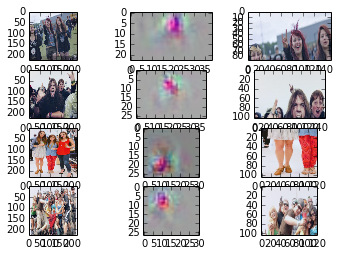

In [18]:
no_feature_map = 144 

test_sort = np.argsort(max_conv5[:,no_feature_map])
for i in xrange(1,5):
    max_file = test_files[test_sort[-i]]
    print max_file, no_feature_map
    net_extract(net,max_file)
    img = np.transpose(net.blobs['data'].data[4,:,:,:],(1,2,0))
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img = img[:,:,::-1]
    plt.subplot(4,3,i*3-2)
    plt.imshow(img)
    pool1_indice = get_pool_indice(net,1,no_feature_map)
    pool2_indice = get_pool_indice(net,2,no_feature_map)
    plt.subplot(4,3,i*3-1)
    
    print pool1_indice.shape
    boundary, outputs_layer1 = recon_conv5(net, no_feature_map, pool1_indice,pool2_indice)
    plt.imshow(outputs_layer1[:,:,::-1])
    plt.subplot(4,3,i*3)
    xmin = max(0, boundary[0]*4);xmax = boundary[1]*4
    ymin = max(0,boundary[2]*4);ymax = boundary[3]*4
    print (xmin, xmax,ymin,ymax)
    plt.imshow(img[xmin:xmax,ymin:ymax,:])

Another feature map(121) which has really nice visualization:

clubber_group_pic00194.jpg 121
(96, 27, 27)
conv5 blob shape: (13, 13)
max index: (12, 11) 152.885 152.885
group:0
conv5 filters and bias: (1, 192, 3, 3) (1,)
reconstructed conv4 blob shape and boundary: (192, 2, 3) [11, 12, 10, 12]
conv4 filters and bias: (192, 192, 3, 3) (192, 1, 1)
conv3 filters and bias: (192, 256, 3, 3) (192, 1, 1)
reconstructed pool2 shape and boundary: (256, 4, 5) [9, 12, 8, 12]
reconstructed conv2 shape and boundary: (256, 9, 11) [18, 26, 16, 26]
conv2 filters and bias: (256, 48, 5, 5) (256, 1, 1)
(10, 96, 27, 27) (96, 13, 15)
reconstructed pool1 shape and boundary: (96, 11, 13) [16, 26, 14, 26]
reconstructed conv1 shape and boundary: (96, 23, 27) [32, 54, 28, 54]
conv1 filters and bias: (96, 3, 11, 11) (96, 1, 1)
reconstructed data shape (23, 27, 3)
(10, 3, 227, 227)
reconstructed data shape and boundary: (23, 27, 3) [32, 54, 28, 54]
(128, 216, 112, 216)
ravers_group_pic00992.jpg 121
(96, 27, 27)
conv5 blob shape: (13, 13)
max index: (6, 7) 142.44 142.44
group

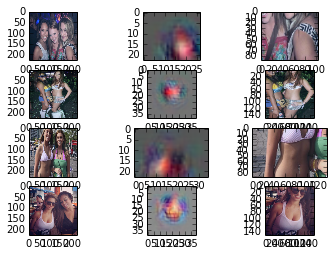

In [19]:
no_feature_map = 121 

test_sort = np.argsort(max_conv5[:,no_feature_map])
for i in xrange(1,5):
    max_file = test_files[test_sort[-i]]
    print max_file, no_feature_map
    net_extract(net,max_file)
    img = np.transpose(net.blobs['data'].data[4,:,:,:],(1,2,0))
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img = img[:,:,::-1]
    plt.subplot(4,3,i*3-2)
    plt.imshow(img)
    pool1_indice = get_pool_indice(net,1,no_feature_map)
    pool2_indice = get_pool_indice(net,2,no_feature_map)
    plt.subplot(4,3,i*3-1)
    
    print pool1_indice.shape
    boundary, outputs_layer1 = recon_conv5(net, no_feature_map, pool1_indice,pool2_indice)
    plt.imshow(outputs_layer1[:,:,::-1])
    plt.subplot(4,3,i*3)
    xmin = max(0, boundary[0]*4);xmax = boundary[1]*4
    ymin = max(0,boundary[2]*4);ymax = boundary[3]*4
    print (xmin, xmax,ymin,ymax)
    plt.imshow(img[xmin:xmax,ymin:ymax,:])